<a href="https://colab.research.google.com/github/ontoligent-design/DS5559/blob/master/first_foray.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assumptions

* Do not preserve punction and whitespace 
* Work with a single text

# Settings

In [77]:
WIDE = (15,5)
THIN = (5,15)

# Imports

In [41]:
import sqlite3
import pandas as pd
import re
import requests
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

# F0: Prepare the source

In [2]:
doc_url = 'https://www.gutenberg.org/files/2701/old/moby10b.txt'
moby_text = requests.get(doc_url).text.split('\r\n')
moby_lines_raw = pd.DataFrame(moby_text, columns=['line'])
moby_lines_raw.index.name = 'line_id'

In [3]:
len(moby_lines_raw.index)

23245

In [4]:
moby_start = 318
moby_end = 23238
moby_lines = moby_lines_raw.loc[moby_start:moby_end].copy()
moby_lines.reset_index(drop=True, inplace=True)
moby_lines.index.name = 'line_id'

In [5]:
moby_lines.head(10)

,line
line_id,
0,ETYMOLOGY.
1,
2,(Supplied by a Late Consumptive Usher to a Gra...
3,
4,"The pale Usher--threadbare in coat, heart, bod..."
5,now. He was ever dusting his old lexicons and...
6,"handkerchief, mockingly embellished with all t..."
7,known nations of the world. He loved to dust ...
8,somehow mildly reminded him of his mortality.


# F1: Identify Chapters and Paragraphs

## Chapters

We apply the **milestone method** to identify, label, and group lines.

In [6]:
moby_lines['chap_ms'] = moby_lines.line\
  .str.match(r'^(?:ETYMOLOGY|CHAPTER \d+|Epilog)')

In [7]:
moby_lines.head()

,line,chap_ms
line_id,,
0,ETYMOLOGY.,True
1,,False
2,(Supplied by a Late Consumptive Usher to a Gra...,False
3,,False
4,"The pale Usher--threadbare in coat, heart, bod...",False


In [8]:
moby_lines['chap_idx'] = None # WHY
moby_lines['chap_idx'] = moby_lines[moby_lines.chap_ms]\
  .apply(lambda x: x.index)
moby_lines.chap_idx = moby_lines.chap_idx.ffill()
moby_lines.chap_idx = moby_lines['chap_idx'].astype('int')

In [9]:
moby_lines.head()

,line,chap_ms,chap_idx
line_id,,,
0,ETYMOLOGY.,True,0
1,,False,0
2,(Supplied by a Late Consumptive Usher to a Gra...,False,0
3,,False,0
4,"The pale Usher--threadbare in coat, heart, bod...",False,0


In [10]:
moby_chaps = moby_lines.groupby('chap_idx').line\
  .apply(lambda x: '\n'.join(x[:])).to_frame().reset_index(drop=True)
moby_chaps.index.name = 'chap_id'

In [11]:
moby_chaps.head()

,line
chap_id,
0,ETYMOLOGY.\n\n(Supplied by a Late Consumptive ...
1,CHAPTER 1\n\nLoomings.\n\n\nCall me Ishmael. ...
2,CHAPTER 2\n\nThe Carpet-Bag.\n\n\nI stuffed a ...
3,CHAPTER 3\n\nThe Spouter-Inn.\n\n\nEntering th...
4,CHAPTER 4\n\nThe Counterpane.\n\n\nUpon waking...


In [12]:
# Optionally removed chapter names here (split and pop off first chunk)

## Paragraphs

In [13]:
moby_paras = moby_chaps.line.str.split(r'\n\n+', expand=True).stack()\
  .to_frame().reset_index().rename(columns={'level_1':'para_id', 0:'para'})
moby_paras.set_index(['chap_id','para_id'], inplace=True)
moby_paras.para = moby_paras.para.str.replace(r'\n', ' ')

In [14]:
moby_paras.head()

para
chap_id para_id                                                   
0       0                                               ETYMOLOGY.
        1        (Supplied by a Late Consumptive Usher to a Gra...
        2        The pale Usher--threadbare in coat, heart, bod...
        3        "While you take in hand to school others, and ...
        4        "WHALE. ... Sw. and Dan. HVAL.  This animal is...

In [15]:
moby_paras.loc[(2,3)].para

'As most young candidates for the pains and penalties of whaling stop at this same New Bedford, thence to embark on their voyage, it may as well be related that I, for one, had no idea of so doing.  For my mind was made up to sail in no other than a Nantucket craft, because there was a fine, boisterous something about everything connected with that famous old island, which amazingly pleased me.  Besides though New Bedford has of late been gradually monopolising the business of whaling, and though in this matter poor old Nantucket is now much behind her, yet Nantucket was her great original--the Tyre of this Carthage;--the place where the first dead American whale was stranded.  Where else but from Nantucket did those aboriginal whalemen, the Red-Men, first sally out in canoes to give chase to the Leviathan?  And where but from Nantucket, too, did that first adventurous little sloop put forth, partly laden with imported cobblestones--so goes the story--to throw at the whales, in order t

# F2: Identify Sentences and Tokens

We identify tokens by delimitter parsing. Delimitters are represented by character classes.

## Sentences

Sentence are actually a container.

In [16]:
moby_sent = moby_paras.para.str.split(r'(?:[":;.?!\(\)]|--)', expand=True)\
  .stack()\
  .to_frame().reset_index().rename(columns={'level_2':'sent_id', 0:'sent'})
moby_sent.set_index(['chap_id', 'para_id', 'sent_id'], inplace=True)
moby_sent = moby_sent[~moby_sent.sent.str.match(r'^\s*$')]

In [17]:
# Re-order the sentence IDs -- NEED TO GENERALIZE THIS PATTERN
moby_sent['new_sent_idx'] = moby_sent.groupby(['chap_id','para_id']).cumcount()
moby_sent = moby_sent.reset_index()
moby_sent.rename(columns={'sent_id':'delete_me'}, inplace=True)
moby_sent.rename(columns={'new_sent_idx':'sent_id'}, inplace=True)
moby_sent = moby_sent.set_index(['chap_id','para_id','sent_id'])['sent']\
  .to_frame()

In [18]:
moby_sent.head()

sent
chap_id para_id sent_id                                                   
0       0       0                                                ETYMOLOGY
        1       0        Supplied by a Late Consumptive Usher to a Gram...
        2       0                                           The pale Usher
                1               threadbare in coat, heart, body, and brain
                2                                            I see him now

## Tokens

In [19]:
moby_tokens = moby_sent.sent.str.split(r'\W+', expand=True).stack()\
  .to_frame().reset_index().rename(columns={'level_3':'token_id', 0:'token'})
moby_tokens.set_index(['chap_id', 'para_id', 'sent_id', 'token_id'], 
                      inplace=True)

In [20]:
moby_tokens.head()

token
chap_id para_id sent_id token_id           
0       0       0       0         ETYMOLOGY
        1       0       0          Supplied
                        1                by
                        2                 a
                        3              Late

In [21]:
moby_tokens['norm'] = moby_tokens.token.str.lower()

In [22]:
moby_tokens.head()

token       norm
chap_id para_id sent_id token_id                      
0       0       0       0         ETYMOLOGY  etymology
        1       0       0          Supplied   supplied
                        1                by         by
                        2                 a          a
                        3              Late       late

# F2: Create Vocabulary

In [23]:
moby_vocab = pd.DataFrame(moby_tokens.token.str.lower().sort_values().unique(), columns=['term'])
moby_vocab.index.name = 'term_id'

In [24]:
moby_vocab.sample(10)

,term
term_id,
12398,restore
13205,shadrach
15793,undergraduate
7148,hind
13293,shilling
6610,grasshopper
11434,preposterous
8038,intervening
6941,hav


## Get Term ID function

In [25]:
def term_id(term):
  try:
    return moby_vocab.query("term == @term").index[0]
  except IndexError as e:
    return None

## Stopwords

In [26]:
stopwords = requests\
  .get('https://algs4.cs.princeton.edu/35applications/stopwords.txt')\
  .text.split('\n')
stopwords[:5]
moby_vocab['sw'] = moby_vocab.term.apply(lambda x: 
                                         x in stopwords 
                                         or len(x) < 2 
                                         or not x.isalpha())

In [27]:
moby_vocab[moby_vocab.term.str.match(r'\d(?:nd|th|st|rd)')]

,term,sw
term_id,,
85,1st,True
101,2nd,True
128,4th,True
142,5th,True


## Replace terms with IDs

In [28]:
moby_tokens['term_id'] = moby_tokens.norm.map(moby_vocab.reset_index()\
  .set_index('term').term_id)\
  .fillna(-1).astype('int')

In [29]:
moby_tokens.head()

token       norm  term_id
chap_id para_id sent_id token_id                               
0       0       0       0         ETYMOLOGY  etymology     5198
        1       0       0          Supplied   supplied    14638
                        1                by         by     2178
                        2                 a          a      190
                        3              Late       late     8580

In [30]:
moby_tokens = moby_tokens[['token','term_id']]

In [31]:
moby_tokens.head()

token  term_id
chap_id para_id sent_id token_id                    
0       0       0       0         ETYMOLOGY     5198
        1       0       0          Supplied    14638
                        1                by     2178
                        2                 a      190
                        3              Late     8580

## Remove stopwords

In [32]:
moby_tokens['sw'] = moby_tokens.term_id.map(moby_vocab.sw)
moby_tokens_ns = moby_tokens.loc[~moby_tokens.sw, ['term_id']]

In [33]:
moby_tokens_ns.head()

term_id
chap_id para_id sent_id token_id         
0       0       0       0            5198
        1       0       0           14638
                        3            8580
                        4            3292
                        5           16179

## Add raw term counts to vocab

In [34]:
moby_vocab['n'] = moby_tokens.groupby('term_id').term_id.count()

In [35]:
n_words = moby_vocab.n.sum()
n_words_adj = moby_vocab[~moby_vocab.sw].n.sum()

In [36]:
n_words, n_words_adj

(231376, 90791)

In [37]:
moby_vocab['freq'] = moby_vocab.n.div(n_words)

In [38]:
moby_vocab.loc[~moby_vocab.sw, 'adj_freq'] = moby_vocab[~moby_vocab.sw].n\
  .div(n_words_adj)

In [39]:
moby_vocab.sample(10)

,term,sw,n,freq,adj_freq
term_id,,,,,
2815,clinging,False,9,0.000039,0.000099
12096,recumbent,False,2,0.000009,0.000022
14506,subtleness,False,1,0.000004,0.000011
4280,dinner,False,18,0.000078,0.000198
8546,lanyard,False,2,0.000009,0.000022
2681,cinders,False,1,0.000004,0.000011
14842,tahiti,False,6,0.000026,0.000066
16749,when,True,606,0.002619,NaN
6907,harvard,False,2,0.000009,0.000022


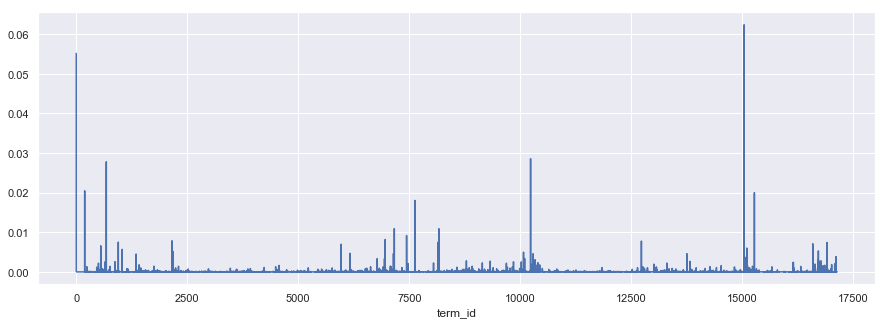

In [78]:
moby_vocab.freq.plot(figsize=WIDE)

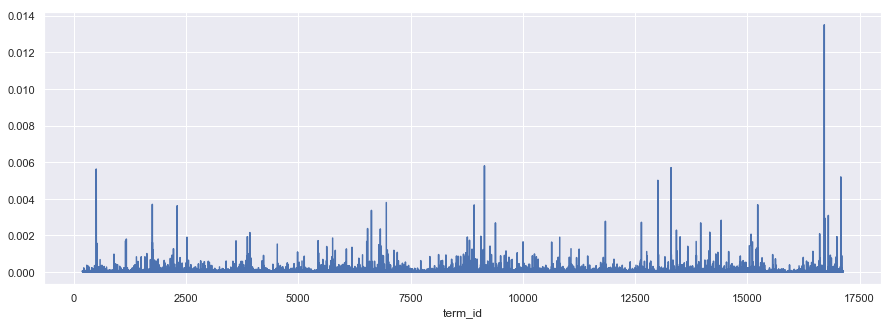

In [79]:
moby_vocab.adj_freq.plot(figsize=WIDE)

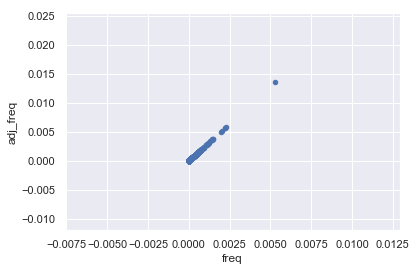

In [46]:
moby_vocab.plot(kind='scatter', x='freq', y='adj_freq')

In [47]:
moby_vocab.loc[moby_vocab.adj_freq.idxmax()].term

'whale'

# Dispersion Plots

## Convert tokens into OHE matrix

In [81]:
kahuna = pd.get_dummies(moby_tokens_ns.reset_index()['term_id']).T
kahuna['term'] = moby_vocab.term
kahuna = kahuna.reset_index().set_index('term').drop('index', axis=1)

In [82]:
kahuna.head()

,0,1,2,3,4,5,6,7,8,9,...,90781,90782,90783,90784,90785,90786,90787,90788,90789,90790
term,,,,,,,,,,,,,,,,,,,,,
aback,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
abaft,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
abandon,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
abandoned,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
abandonedly,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Default method

In [87]:
def get_term_dplot(term, figsize=(15,.5)):
  print(term)
  kahuna.loc[term].plot(figsize=figsize)
  plt.show()

stubb


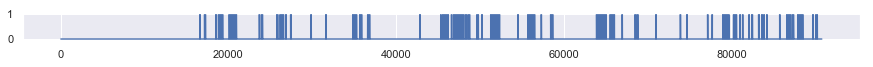

ahab


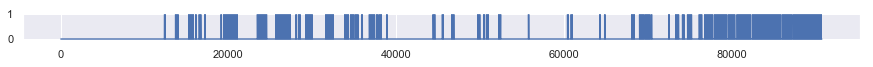

whale


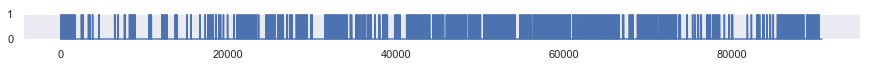

starbuck


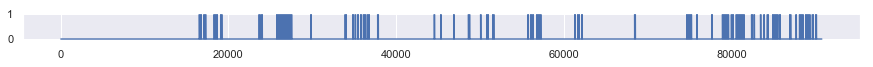

queequeg


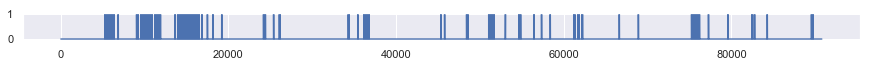

ishmael


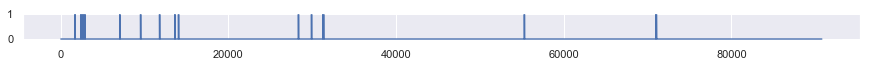

white


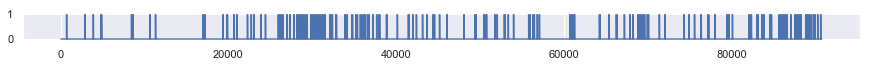

sea


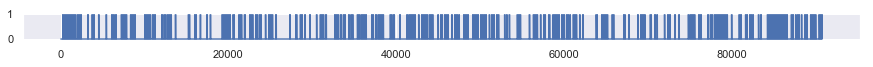

ship


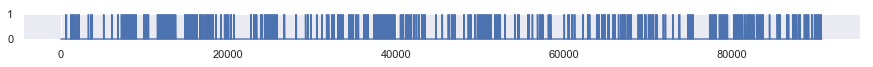

church


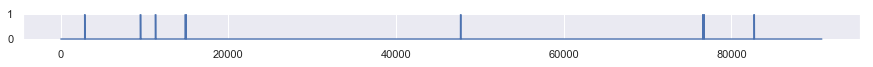

death


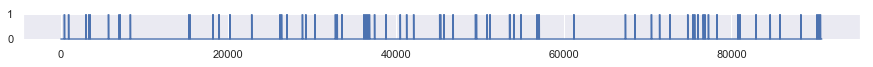

In [151]:
terms = ['stubb', 'ahab','whale', 'starbuck', 'queequeg', 'ishmael', 'white', 'sea', 'ship', 'church', 'death']
for term in terms:
  get_term_dplot(term)

## Seaborn method

In [97]:
viz_df = kahuna.loc[terms].T\
  .stack()\
  .to_frame()\
  .reset_index()\
  .rename(columns={'level_0': 't', 'level_1':'term', 0:'n'})

In [98]:
viz_df[viz_df.n > 0].sample(5)

,t,term,n
960682,87334,ship,1
707038,64276,whale,1
469663,42696,sea,1
165750,15068,whale,1
227477,20679,ship,1


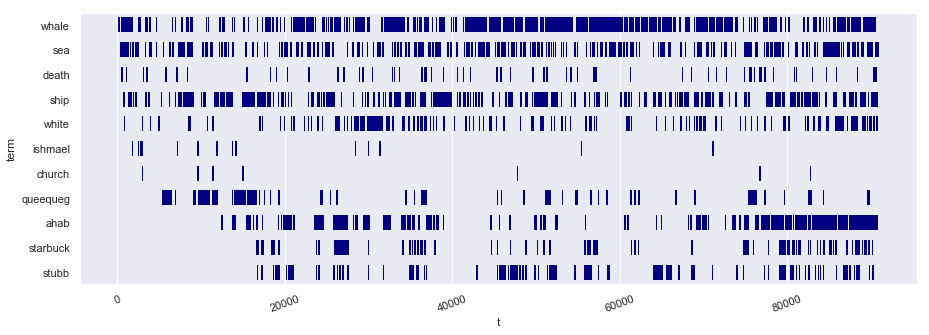

In [99]:
plt.figure(figsize=WIDE)
sns.stripplot(y='term', x='t', data=viz_df[viz_df.n == 1],
 orient='h', marker="$|$", color='navy', size=15, jitter=0)
plt.xticks(rotation=20)
# plt.tight_layout()
plt.show()

# F3: Create BOWs

## BOW by Para


In [100]:
moby_bow = moby_tokens_ns\
  .groupby(['chap_id','para_id','term_id'])\
  .term_id.count()\
  .to_frame().rename(columns={'term_id':'n'})

In [101]:
moby_bow.head()

n
chap_id para_id term_id   
0       0       5198     1
        1       3292     1
                6584     1
                8580     1
                12913    1

## BOW by Chap

In [102]:
moby_bow_chaps = moby_tokens_ns\
  .groupby(['chap_id','term_id'])\
  .term_id.count()\
  .to_frame().rename(columns={'term_id':'n'})

In [103]:
moby_bow_chaps.head()

n
chap_id term_id   
0       223      1
        259      1
        260      1
        289      2
        319      1

## BOW by Chunk

In [104]:
moby_tokens_ns['ord'] = moby_tokens_ns.reset_index().index + 1

In [105]:
# Divide text evenly in K chunks
K = 100
N = moby_tokens_ns.ord.max()
C = int(round(N / K))
T = C * K

In [106]:
N, K, C, T

(90791, 100, 908, 90800)

In [107]:
moby_tokens_ns['chunk'] = moby_tokens_ns.ord.div(C).round().astype('int')

In [108]:
moby_tokens_ns.head()

term_id  ord  chunk
chap_id para_id sent_id token_id                     
0       0       0       0            5198    1      0
        1       0       0           14638    2      0
                        3            8580    3      0
                        4            3292    4      0
                        5           16179    5      0

In [109]:
moby_bow_chunks = moby_tokens_ns\
  .groupby(['chunk','term_id'])\
  .term_id.count()\
  .to_frame().rename(columns={'term_id':'n'})

In [110]:
moby_bow_chunks.head()

n
chunk term_id   
0     319      1
      441      1
      466      1
      543      1
      580      1

# F3: Create DTMs

## DTM by Para

In [111]:
moby_dtm = moby_bow.unstack().fillna(0)
moby_dtm.columns = moby_dtm.columns.droplevel()

In [112]:
moby_dtm.head()

term_id          191    192    193    194    195    196    197    198    \
chap_id para_id                                                           
0       0          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
        1          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
        2          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
        3          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
        4          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

term_id          199    200    ...    17129  17130  17131  17132  17133  \
chap_id para_id                ...                                        
0       0          0.0    0.0  ...      0.0    0.0    0.0    0.0    0.0   
        1          0.0    0.0  ...      0.0    0.0    0.0    0.0    0.0   
        2          0.0    0.0  ...      0.0    0.0    0.0    0.0    0.0   
        3          0.0    0.0  ...      0.0    0.0    0.0    0.0    0.0   
        4          0.0    0.0  ...      0.0    0.0    0.0    0.0    0.0   

term_id          17134  17135  17136  17137  17138  
chap_id para_id                                     
0       0          0.0    0.0    0.0    0.0    0.0  
        1          0.0    0.0    0.0    0.0    0.0  
        2          0.0    0.0    0.0    0.0    0.0  
        3          0.0    0.0    0.0    0.0    0.0  
        4          0.0    0.0    0.0    0.0    0.0  

[5 rows x 16487 columns]

## DTM by Chap

In [113]:
moby_dtm_chaps = moby_bow_chaps.unstack().fillna(0)
moby_dtm_chaps.columns = moby_dtm_chaps.columns.droplevel()

In [114]:
moby_dtm_chaps.head()

term_id,191,192,193,194,195,196,197,198,199,200,...,17129,17130,17131,17132,17133,17134,17135,17136,17137,17138
chap_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## DTM by Chunk

In [115]:
moby_dtm_chunks = moby_bow_chunks.unstack().fillna(0)
moby_dtm_chunks.columns = moby_dtm_chunks.columns.droplevel()

In [116]:
moby_dtm_chunks.head()

term_id,191,192,193,194,195,196,197,198,199,200,...,17129,17130,17131,17132,17133,17134,17135,17136,17137,17138
chunk,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Some graphs

In [117]:
WHALE = term_id('whale')
AHAB = term_id('ahab')

In [118]:
WIDE = (15, 3)
THIN = (3, 10)

In [119]:
# term_ids = [term_id(term) for term in terms]
# df = moby_dtm[term_ids].stack().to_frame().rename(columns={0:'n'})
# df.head()
# g = sns.FacetGrid(df.reset_index(), row='term_id', aspect=5)
# g = g.map(plt.plot, 'n')

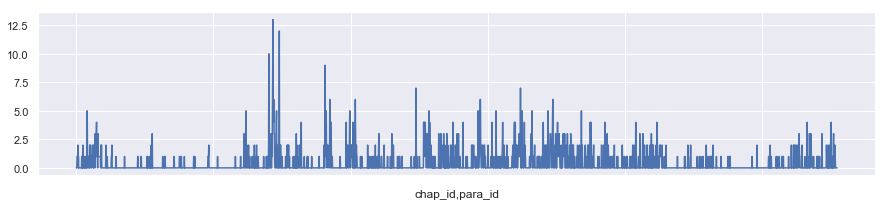

In [120]:
moby_dtm[WHALE].plot(figsize=WIDE)

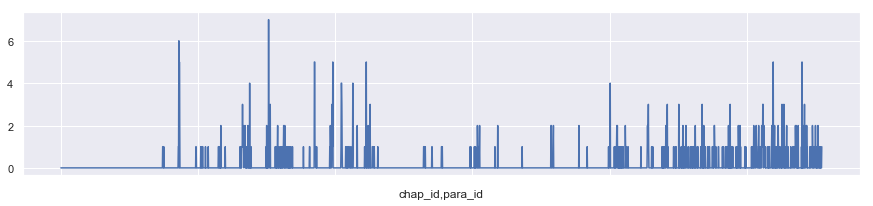

In [121]:
moby_dtm[AHAB].plot(figsize=WIDE)

# Create TFIDF Matrix

## Get N docs

In [122]:
N = len(moby_dtm.index)

In [123]:
N

2774

## TFIDF  by Para

In [124]:
moby_dtm_tfidf = moby_dtm.apply(lambda row: row / row.sum(), 1).apply(lambda col: col * np.log(N/col[col > 0].count()))

In [125]:
moby_bow['tfidf'] = moby_dtm_tfidf.stack().to_frame().rename(columns={0:'tfidf'})

In [126]:
moby_bow.sort_values('tfidf', ascending=False).head()

,,,n,tfidf
chap_id,para_id,term_id,,
0,0,5198,1,7.928046
25,1,11319,1,7.928046
12,1,1598,1,7.928046
11,1,10008,1,7.928046
1,1,8940,1,7.928046


In [127]:
moby_dtm_tfidf.head()

term_id          191    192    193    194    195    196    197    198    \
chap_id para_id                                                           
0       0          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
        1          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
        2          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
        3          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
        4          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

term_id          199    200    ...    17129  17130  17131  17132  17133  \
chap_id para_id                ...                                        
0       0          0.0    0.0  ...      0.0    0.0    0.0    0.0    0.0   
        1          0.0    0.0  ...      0.0    0.0    0.0    0.0    0.0   
        2          0.0    0.0  ...      0.0    0.0    0.0    0.0    0.0   
        3          0.0    0.0  ...      0.0    0.0    0.0    0.0    0.0   
        4          0.0    0.0  ...      0.0    0.0    0.0    0.0    0.0   

term_id          17134  17135  17136  17137  17138  
chap_id para_id                                     
0       0          0.0    0.0    0.0    0.0    0.0  
        1          0.0    0.0    0.0    0.0    0.0  
        2          0.0    0.0    0.0    0.0    0.0  
        3          0.0    0.0    0.0    0.0    0.0  
        4          0.0    0.0    0.0    0.0    0.0  

[5 rows x 16487 columns]

## TFIDF by Chap

In [128]:
moby_dtm_tfidf_chaps = moby_dtm_chaps.apply(lambda row: row / row.sum(), 1).apply(lambda col: col * np.log(N/col[col > 0].count()))

In [129]:
moby_bow_chaps['tfidf'] = moby_dtm_tfidf_chaps.stack().to_frame().rename(columns={0:'tfidf'})

In [130]:
moby_dtm_tfidf_chaps.head()

term_id,191,192,193,194,195,196,197,198,199,200,...,17129,17130,17131,17132,17133,17134,17135,17136,17137,17138
chap_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.00815,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.013693,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## TFIDF by Chunk

In [131]:
moby_dtm_tfidf_chunks = moby_dtm_chunks.apply(lambda row: row / row.sum(), 1).apply(lambda col: col * np.log(N/col[col > 0].count()))

In [132]:
moby_bow_chunks['tfidf'] = moby_dtm_tfidf_chunks.stack().to_frame().rename(columns={0:'tfidf'})

In [133]:
moby_bow_chunks

n     tfidf
chunk term_id             
0     319      1  0.015043
      441      1  0.015936
      466      1  0.017463
      543      1  0.015936
      580      1  0.013918
      586      1  0.009569
      608      1  0.010123
      675      1  0.010864
      689      1  0.017463
      695      1  0.011813
      704      1  0.015043
      778      1  0.017463
      800      1  0.012882
      801      1  0.015043
      802      1  0.013177
      860      1  0.012391
      909      1  0.017463
      931      1  0.010556
      1100     1  0.015043
      1108     1  0.015043
      1117     1  0.017463
      1184     1  0.017463
      1205     1  0.017463
      1212     1  0.017463
      1220     1  0.017463
      1374     2  0.030086
      1380     1  0.012623
      1487     1  0.017463
      1580     1  0.015936
      1602     1  0.012181
...           ..       ...
100   15627    1  0.009096
      15628    1  0.009505
      15769    1  0.017776
      15780    1  0.017776
      15831    1  0.015313
      15900    1  0.016222
      16084    1  0.017776
      16150    1  0.012613
      16154    1  0.014668
      16161    1  0.014167
      16163    1  0.011559
      16200    1  0.014167
      16267    1  0.012849
      16350    1  0.015313
      16406    1  0.010386
      16419    1  0.013113
      16435    1  0.017776
      16454    2  0.035552
      16612    2  0.016312
      16715    3  0.022626
      16742    1  0.014167
      16747    1  0.017776
      16805    1  0.008187
      16887    1  0.012849
      16967    1  0.010650
      17033    1  0.012613
      17073    2  0.021899
      17082    1  0.015313
      17083    4  0.033129
      17087    1  0.009005

[64553 rows x 2 columns]

In [134]:
moby_dtm_tfidf_chunks.head()

term_id,191,192,193,194,195,196,197,198,199,200,...,17129,17130,17131,17132,17133,17134,17135,17136,17137,17138
chunk,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.007513,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.008741,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Term Frequency Graphs

## TFIDF by Para

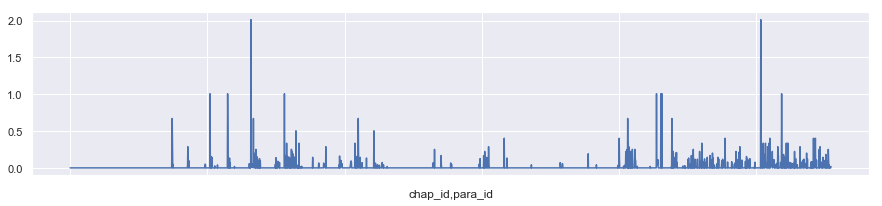

In [135]:
moby_dtm_tfidf.T.loc[AHAB].plot(figsize=WIDE)

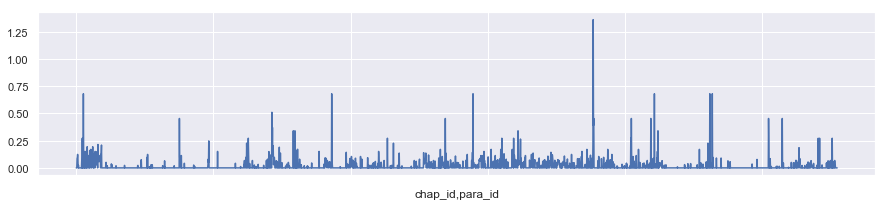

In [136]:
moby_dtm_tfidf.T.loc[WHALE].plot(figsize=WIDE)

## TFIDF by Chap

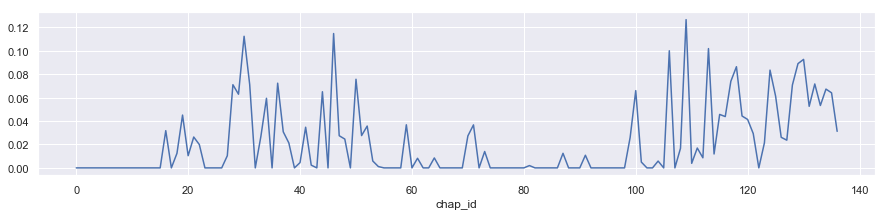

In [137]:
moby_dtm_tfidf_chaps.T.loc[AHAB].plot(figsize=WIDE)

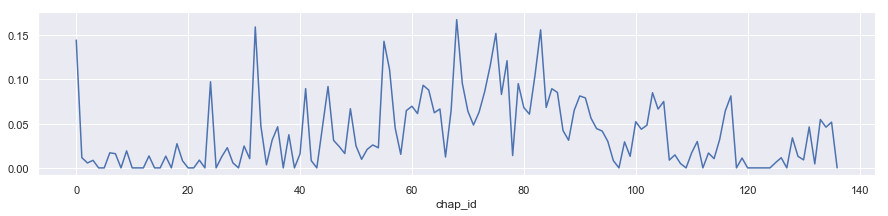

In [138]:
moby_dtm_tfidf_chaps.T.loc[WHALE].plot(figsize=WIDE)

## TFIDF by Chunk

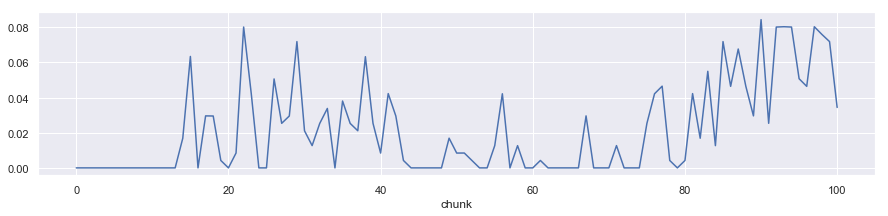

In [139]:
moby_dtm_tfidf_chunks.T.loc[AHAB].plot(figsize=WIDE)

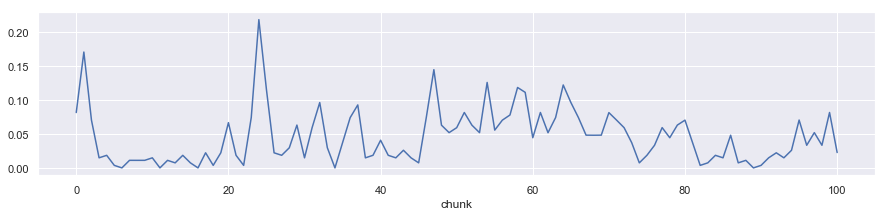

In [140]:
moby_dtm_tfidf_chunks.T.loc[WHALE].plot(figsize=WIDE)

# Term Correlations

In [152]:
#terms = ['man', 'ahab', 'whale', 'white', 'starbuck', 'queequeg', 'church','shark']
corr_terms = [term_id(term) for term in terms]
corr_cols = {term_id(term):term for term in terms}

In [173]:
def corr_plot_terms(terms, dtm, title='Foo'):
    plt.figure(figsize = (10,10))
    print(title)
    corr = dtm[corr_terms].rename(columns=corr_cols).corr()
    sns.heatmap(corr, vmax=.3, annot=True, center=0, 
              cmap='RdYlGn',
              square=True, linewidths=.5, 
              cbar_kws={"shrink": .5})

In [167]:
def corr_frame_terms(terms, dtm, title='Foo'):
  print(title)
  corr = dtm[corr_terms].rename(columns=corr_cols).corr()
  corr.index.name = 'src_term'
  corr = corr.stack().to_frame()\
    .reset_index()\
    .rename(columns={0:'corr'})\
    .sort_values('corr').reset_index()
  corr = corr.query('src_term != term_id').copy()
  corr['test'] = corr.index % 2
  corr = corr[corr.test == 0]
  corr = corr[['src_term','term_id','corr']]
  corr.columns = ['src_term','dst_term','corr']
  return pd.concat([corr.head(), corr.tail()])\
    .sort_values('corr', ascending=False)

In [168]:
corr_frame_terms(terms, moby_dtm_tfidf, 'By Para')

By Para


,src_term,dst_term,corr
108,white,whale,0.284180
106,stubb,church,0.070454
104,ahab,starbuck,0.057157
102,white,ishmael,0.043620
100,queequeg,church,0.035766
8,queequeg,ahab,-0.026384
6,stubb,sea,-0.026806
4,sea,whale,-0.027473
2,queequeg,whale,-0.029715
0,whale,starbuck,-0.035049


In [162]:
corr_frame_terms(terms, moby_dtm_tfidf_chaps, 'By Chap')

By Chap


,src_term,dst_term,corr
108,death,church,0.470659
106,starbuck,ahab,0.333745
104,ahab,white,0.299730
102,starbuck,stubb,0.293632
100,church,queequeg,0.195523
8,queequeg,ahab,-0.161857
6,white,queequeg,-0.162016
4,whale,starbuck,-0.216786
2,queequeg,whale,-0.245843
0,whale,ahab,-0.261622


In [163]:
corr_frame_terms(terms, moby_dtm_tfidf_chunks, 'By Chunk')

By Chunk


,src_term,dst_term,corr
108,queequeg,church,0.483839
106,ahab,starbuck,0.441710
104,white,ahab,0.278076
102,starbuck,stubb,0.179011
100,ahab,ship,0.170160
8,starbuck,ishmael,-0.161779
6,church,whale,-0.167472
4,church,ship,-0.198790
2,whale,ahab,-0.267526
0,whale,queequeg,-0.302436


## By Para

By Para


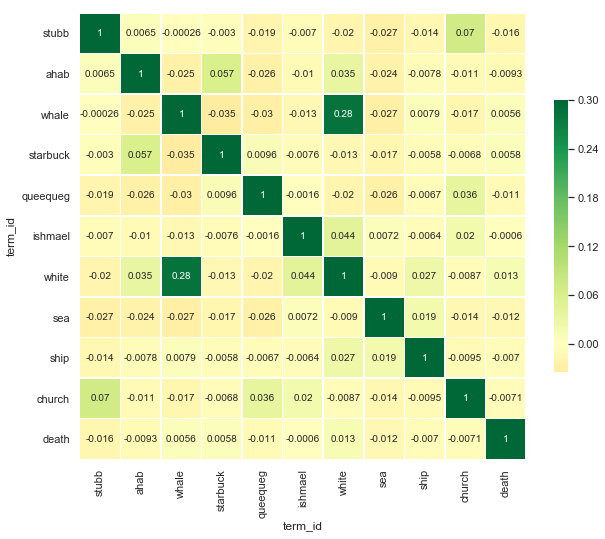

In [174]:
corr_plot_terms(terms, moby_dtm_tfidf, 'By Para')

## By Chap

By Chap


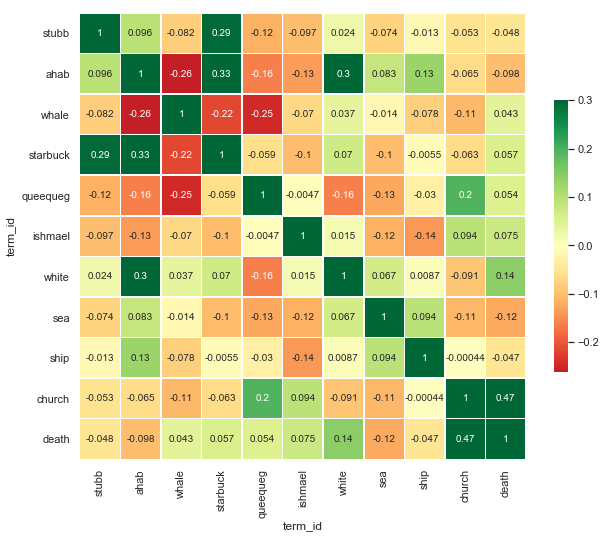

In [175]:
corr_plot_terms(terms, moby_dtm_tfidf_chaps, 'By Chap')

## By Chunk

By Chunk


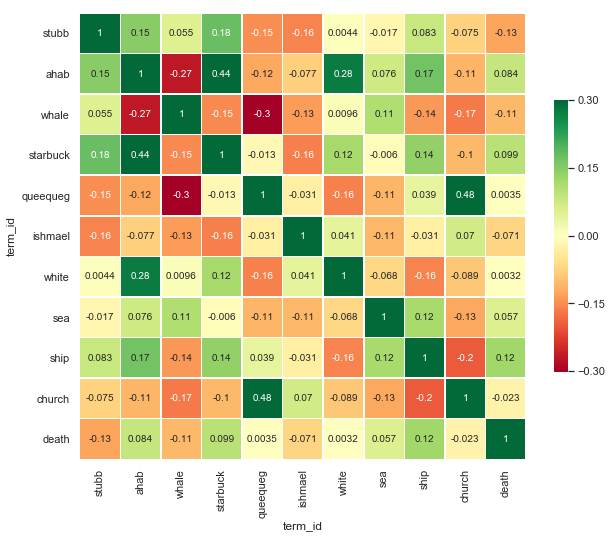

In [176]:
corr_plot_terms(terms, moby_dtm_tfidf_chunks, 'By Chunk')

# PMI

In [234]:
moby_vocab

,term,sw,n,freq,adj_freq
term_id,,,,,
0,,True,12761,0.055153,NaN
1,000,True,20,0.000086,NaN
2,1,True,2,0.000009,NaN
3,10,True,4,0.000017,NaN
4,100,True,1,0.000004,NaN
5,101,True,1,0.000004,NaN
6,102,True,1,0.000004,NaN
7,103,True,1,0.000004,NaN
8,104,True,1,0.000004,NaN


In [ ]:
moby_bow_chaps.head()

n     tfidf
chap_id term_id             
0       223      1  0.004248
        259      1  0.003841
        260      1  0.004010
        289      2  0.005530
        319      1  0.004010

In [ ]:
n_chaps = len(moby_dtm_chaps.index)

In [ ]:
n_chaps

137

In [ ]:
moby_bow_chaps.groupby('term_id').n.count().div(n_chaps).sort_values(ascending=False).head()

term_id
2520     0.992701
9146     0.832117
16715    0.795620
8918     0.781022
13008    0.737226
Name: n, dtype: float64

In [ ]:
moby_vocab.loc[8918].term

'long'